In [1]:
from pyspark import SparkContext
sc = SparkContext()

In [2]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *

sqlContext = SQLContext(sc)
schema = StructType([ \
    StructField("state", StringType(), True), \
    StructField("account_length", DoubleType(), True), \
    StructField("area_code", StringType(), True), \
    StructField("phone_number", StringType(), True), \
    StructField("intl_plan", StringType(), True), \
    StructField("voice_mail_plan", StringType(), True), \
    StructField("number_vmail_messages", DoubleType(), True), \
    StructField("total_day_minutes", DoubleType(), True), \
    StructField("total_day_calls", DoubleType(), True), \
    StructField("total_day_charge", DoubleType(), True), \
    StructField("total_eve_minutes", DoubleType(), True), \
    StructField("total_eve_calls", DoubleType(), True), \
    StructField("total_eve_charge", DoubleType(), True), \
    StructField("total_night_minutes", DoubleType(), True), \
    StructField("total_night_calls", DoubleType(), True), \
    StructField("total_night_charge", DoubleType(), True), \
    StructField("total_intl_minutes", DoubleType(), True), \
    StructField("total_intl_calls", DoubleType(), True), \
    StructField("total_intl_charge", DoubleType(), True), \
    StructField("number_customer_service_calls", DoubleType(), True), \
    StructField("churned", StringType(), True)])

churn_data = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .load('data/churn.csv', schema = schema)

In [3]:
count = churn_data.count()
voice_mail_plans = churn_data.filter(churn_data.voice_mail_plan == " yes").count()
print('Count: {0}, voice_mail_plans: {1}'.format(count,voice_mail_plans))

Count: 5000, voice_mail_plans: 1323


In [4]:
churn_data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
account_length,5000,100.2586,39.69455954726706,1.0,243.0
number_vmail_messages,5000,7.7552,13.546393391408023,0.0,52.0
total_day_minutes,5000,180.28889999999993,53.89469916893225,0.0,351.5
total_day_calls,5000,100.0294,19.831197415138185,0.0,165.0
total_day_charge,5000,30.64966799999995,9.162068691639364,0.0,59.76
total_eve_minutes,5000,200.63656000000023,50.55130896756355,0.0,363.7
total_eve_calls,5000,100.191,19.82649583227953,0.0,170.0
total_eve_charge,5000,17.05432199999998,4.296843300934603,0.0,30.91
total_night_minutes,5000,200.39161999999996,50.52778925772484,0.0,395.0


In [5]:
from pyspark.sql.functions import *

GroupBy Aggregation, Join, Column manipulations

In [6]:
states=churn_data.groupBy("state").count()
states_vm=churn_data.filter(churn_data.voice_mail_plan == " yes").groupBy("state") \
    .count().withColumnRenamed('count', 'count_vm')
joined_df = states.join(states_vm, states.state == states_vm.state, 'inner').drop(states_vm.state)
df=joined_df.select(joined_df['state'],(joined_df['count_vm']/joined_df['count']).alias('vmp'))
df.show()

+-----+-------------------+
|state|                vmp|
+-----+-------------------+
|   MS|0.30303030303030304|
|   MT|0.31313131313131315|
|   TN|0.25842696629213485|
|   NC| 0.2967032967032967|
|   ND| 0.2840909090909091|
|   NE| 0.2159090909090909|
|   AK| 0.3055555555555556|
|   NH|0.29473684210526313|
|   AL|0.24193548387096775|
|   NJ|0.24107142857142858|
|   TX|0.19827586206896552|
|   NM| 0.2087912087912088|
|   AR|0.34782608695652173|
|   NV|0.23333333333333334|
|   AZ|0.33707865168539325|
|   HI|0.23255813953488372|
|   NY|0.21929824561403508|
|   UT| 0.2767857142857143|
|   OH| 0.3448275862068966|
|   OK| 0.2222222222222222|
+-----+-------------------+
only showing top 20 rows



Convert from Spark DataFrame to Pandas DataFrame. 
[df.sample(withReplacement, fraction, seed=None)]

In [7]:
sample_data = churn_data.sample(False, 0.5, 83).toPandas()
sample_data.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128.0,415,382-4657,no,yes,25.0,265.1,110.0,45.07,...,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1.0,False.
1,OH,107.0,415,371-7191,no,yes,26.0,161.6,123.0,27.47,...,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1.0,False.
2,NJ,137.0,415,358-1921,no,no,0.0,243.4,114.0,41.38,...,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0.0,False.
3,OK,75.0,415,330-6626,yes,no,0.0,166.7,113.0,28.34,...,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3.0,False.
4,AL,118.0,510,391-8027,yes,no,0.0,223.4,98.0,37.98,...,101.0,18.75,203.9,118.0,9.18,6.3,6.0,1.70,0.0,False.


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

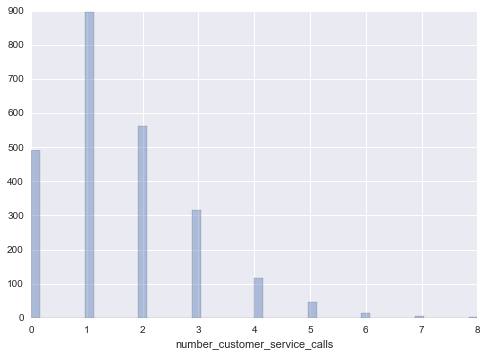

In [9]:
#pd.DataFrame.hist(data=sample_data,column='number_customer_service_calls')
sb.distplot(sample_data['number_customer_service_calls'], kde=False)

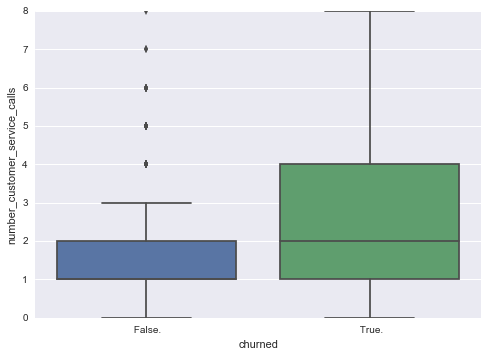

In [10]:
sb.boxplot(x="churned", y="number_customer_service_calls", data=sample_data)

Separating columns by type.

In [11]:
numeric_cols = ["account_length", "number_vmail_messages", "total_day_minutes",
                "total_day_calls", "total_day_charge", "total_eve_minutes",
                "total_eve_calls", "total_eve_charge", "total_night_minutes",
                "total_night_calls", "total_intl_minutes", "total_intl_calls",
                "total_intl_charge"]
reduced_numeric_cols = ["account_length", "number_vmail_messages", "total_day_calls",
                        "total_day_charge", "total_eve_calls", "total_eve_charge",
                        "total_night_calls", "total_intl_calls", "total_intl_charge"]
categorical_cols = ["state", "international_plan", "voice_mail_plan", "area_code"]

Preparing data for classifiers

In [12]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

label_indexer = StringIndexer(inputCol = 'churned', outputCol = 'label')
plan_indexer = StringIndexer(inputCol = 'intl_plan', outputCol = 'intl_plan_indexed')

assembler = VectorAssembler(
    inputCols = ['intl_plan_indexed'] + reduced_numeric_cols,
    outputCol = 'features')

Decision Tree

In [13]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

classifier = DecisionTreeClassifier(labelCol = 'label', featuresCol = 'features')

pipeline = Pipeline(stages=[plan_indexer, label_indexer, assembler, classifier])

(train, test) = churn_data.randomSplit([0.7, 0.3])
model = pipeline.fit(train)

Model Evaluation

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator()
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
print('The AUROC is {0} and the AUPR is {1}'.format(auroc, aupr))

The AUROC is 0.4843505477308294 and the AUPR is 0.2349521131528619


Random Forest

In [15]:
from pyspark.ml.classification import RandomForestClassifier
classifier = RandomForestClassifier(labelCol = 'label', featuresCol = 'features', numTrees=500, seed=201)
pipeline = Pipeline(stages=[plan_indexer, label_indexer, assembler, classifier])
#(train, test) = churn_data.randomSplit([0.7, 0.3])
model = pipeline.fit(train)
predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator()
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
print('The AUROC is {0} and the AUPR is {1}'.format(auroc, aupr))

The AUROC is 0.805198638223102 and the AUPR is 0.6728903590504192


numTrees=20: The AUROC is 0.8034334855914316 and the AUPR is 0.6880744080071193